# Fitting by Frame 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         
from os.path import dirname as parent_folde
import pandas as pd

In [611]:
sys.path.append('../AppStat/AppStat2021/External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax

sys.path.append('../AppStat/AppStat2021/Emilie_External_Functions')
from EmilieExternalFunctions import zerobin_hist, chi2_test, get_chi2_values

sys.path.append('BachelorExternalFunctions')
from Bachelor_ExternalFunctions import peak_plotter, peak_finder, compare_peaks
from Bachelor_ExternalFunctions import amp_plotter, amplitudes, get_min_idx

In [131]:
# Set som plotting standards:

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)


save_plots = True

In [4]:
r = np.random # Random generator
r.seed(41)    # Set a random seed (but a fixed one)
pi = np.pi

In [5]:
# Getting the data and converting to numpy array: 

dataframe_m = pd.read_csv('Data/mdata.csv', header=None, index_col=None)
dataframe_p = pd.read_csv('Data/pdata.csv', header=None, index_col=None)

dataframe_m = dataframe_m.to_numpy()
dataframe_p = dataframe_p.to_numpy()

In [6]:
# Identifying and saving the traces, where the concentration gets very small. 

removed_traces_m = []
removed_idx = [] 
removed_traces_p = []

for i in range(0, 422): 
    for j in range(49, 287):  # Ocsillation should begin after the 49th datapoint. 
        if dataframe_m[i][j] < 0.1: 
            removed_traces_m.append(dataframe_m[i])
            removed_traces_p.append(dataframe_p[i])
            removed_idx.append(i)
            
        if dataframe_p[i][j] < 0.1: 
            removed_traces_m.append(dataframe_m[i])
            removed_traces_p.append(dataframe_p[i])
            removed_idx.append(i)
            break

In [7]:
# Cleaning the dataframes for traces:  

data_m = np.delete(dataframe_m, removed_idx, 0)
data_p = np.delete(dataframe_p, removed_idx, 0)

In [8]:
# Finding the average fluctuations before oscillations to use as a baseline/initial error for fitting

fluct_m = [(np.std(data_m[i][:49], ddof=1)) for i in range(len(data_m))]  
fluct_p = [(np.std(data_p[i][:49], ddof=1)) for i in range(len(data_p))]

avefluct_m = np.mean(fluct_m)  # Maybe use mode/median instead
avefluct_p = np.mean(fluct_p)

print(f'The mean fluctuations before oscillations: {avefluct_m:.2f}(mdm2) and {avefluct_p:.2f}(p53)')

The mean fluctuations before oscillations: 9.34(mdm2) and 22.37(p53)


In [292]:
# Removing noise by fitting a fourth order polynomium: 

def remove_noise(x, p0, p1, p2, p3, p4): 
    return p0 + p1*x + p2*x**2 + p3*x**3 + p4*x**4

time = np.linspace(0, 287/2, 287)
t = time[49:]

# Calculation the residuals for all of the data series: 

resi_m = []
resi_p = []

for i in range(len(data_m)): 
    
    fit_obj_m = Chi2Regression(remove_noise, t, data_m[i][49:], avefluct_m)
    fit_obj_p = Chi2Regression(remove_noise, t, data_p[i][49:], avefluct_p)

    minuit_m = Minuit(fit_obj_m, 30, 1, 1, 1, 1)
    minuit_p = Minuit(fit_obj_p, 30, 1, 1, 1, 1)
    
    minuit_m.errordef = 1.0  
    minuit_p.errordef = 1.0 

    minuit_m.migrad() 
    minuit_p.migrad()
    
    resi_m.append(data_m[i][49:] - remove_noise(t, *minuit_m.values[:]))
    resi_p.append(data_p[i][49:] - remove_noise(t, *minuit_p.values[:]))
    
print(f'The mean of the p53 and Mdm2 residuals: {np.mean(resi_p):.5f} and {np.mean(resi_m):.6f}')

The mean of the p53 and Mdm2 residuals: -0.00015 and -0.000031


In [10]:
# Shifting all mdm2 traces three places: 

roll_resi_m = np.zeros(shape=(402, 238))

for i in range(len(resi_m)): 
    roll_resi_m[i] = np.roll(resi_m[i], -3)

In [25]:
# Fit functions

def tend_line(x, a, b): 
    return a * (x - x.mean()) + b 

def fit_func(t, offset, amp, freq, phase): 
    return offset + amp * np.sin(2*pi*freq * t + phase)

In [93]:
from IPython.display import clear_output

def fit_by_frame(t, data, datapoints, tend_line, fit_func, sy, initial_values, ax=None):
    
    # Setting up lists for data:
    new_frames = [] 
    
    fit_values = [] 
    fit_errors = []

    Chi2 = [] 
    Pval = [] 
    
    
    # Defining the initial values: 
    offset, amp, freq, phase = initial_values[:]

    # Running the loop, that fits every frame: 
    for i in range(0, len(t)-datapoints): 
        timeframe = t[i:datapoints+i]
        dataframe = data[i:datapoints+i]
    
    
        # Fitting a straight line to remove linear tendency: 
        fit_obj0 = Chi2Regression(tend_line, timeframe, dataframe, sy)

        minuit0 = Minuit(fit_obj0, -4, np.mean(dataframe))
        minuit0.errordef = 1.0     
        minuit0.migrad()
    
    
        # The new dataframe without linear tendency: 
        new_frame = dataframe - tend_line(timeframe, *minuit0.values[:])
        new_frames.append(new_frame)
        
        
        # Lists with variations initial values to choose from:
        random_offset = [3, 4, 5, 6, 7] 
        random_freq = [-0.01, -0.025, -0.05, -0.07, 0.07, 0.05, 0.025, 0.01] 
        random_amp = [2, 4, 6, 8, 10]
        random_phase = [-pi/6, -pi/4, -pi/2, -pi, pi, pi/2, pi/4, pi/6]
        
        # List for fit values for each j: 
        trial_values = []
        trial_errors = []
        trial_Chi2 = [] 
        trial_Pval = []
        
        # Fitting the frame: 
        for j in range(100):
            
            fit_obj = Chi2Regression(fit_func, timeframe, new_frame, sy)

            minuit = Minuit(fit_obj, offset, amp, freq, phase)
            
            minuit.limits['offset'] = (-50, 50)          # Limiting parameters
            minuit.limits['amp'] = (-300, 300)
            minuit.limits['freq'] = (0.01, 0.8)
            minuit.limits['phase'] = (-2*pi, 2*pi)
            
            minuit.errordef = 1.0     
            minuit.migrad()
        
            Ndof = datapoints - minuit.nfit
            chi2_value = minuit.fval
            p_value = stats.chi2.sf(chi2_value, Ndof)
            
            trial_values.append(minuit.values[:])
            trial_errors.append(minuit.errors[:])
            trial_Chi2.append(chi2_value)
            trial_Pval.append(p_value)
            
            
            if j == 0 and i == 0: 
                fit_values.append(trial_values[-1])
                fit_errors.append(trial_errors[-1])
                Chi2.append(trial_Chi2[-1])
                Pval.append(trial_Pval[-1])
                

            else: 
               
                if minuit.valid and p_value >= 0.05:      
                    break

                else:
                    offset = fit_values[-1][0] + r.choice(random_offset)
                    amp = fit_values[-1][1] - r.choice(random_amp)
                    freq = fit_values[-1][2] + r.choice(random_freq)
                    phase = r.choice(random_phase)
                
        if i > 0: 
            idx = np.argmax(trial_Pval)
            Chi2.append(trial_Chi2[idx])
            Pval.append(trial_Pval[idx])
            fit_values.append(trial_values[idx][:])
            fit_errors.append(trial_errors[idx][:])
    
            offset, amp, freq, phase = fit_values[-1][:]

    
        if ax: 
            
            ax.cla()
            ax.plot(timeframe, new_frame, color='cornflowerblue',label='Data')
            ax.plot(timeframe, new_frame, marker='x', ms=8, mew=2.5, color='cornflowerblue')
            
            taxis = np.linspace(t[i], t[datapoints + i], 100)
            ax.plot(taxis, fit_func(taxis, *fit_values[-1][:]), color='hotpink', label='Fit')
        
            ax.set(xlabel='Time', 
                    ylabel='Concentration', 
                    title=f'Frame {i}')
            
            ax.legend()
        
            d = {'Offset':   [minuit.values['offset'], minuit.errors['offset']],
                 'Amplitude':       [minuit.values['amp'], minuit.errors['amp']],
                 'Frequency':       [minuit.values['freq'], minuit.errors['freq']],
                 'Phase':       [minuit.values['phase'], minuit.errors['phase']],
                 'Chi2':     chi2_value,
                 'Prob':     p_value,
                 }

            text = nice_string_output(d, extra_spacing=2, decimals=3)
            add_text_to_ax(0.6, 0.9, text, ax, fontsize=16, color='black')
            
            display(fig)
            clear_output(wait = True)
            plt.pause(0.05)
    
    for i in range(0, len(Chi2) - 1): 
        
        if Chi2[i] > datapoints > Chi2[i+1]:  # Bad i'th fit but good (i+1)'th fit. 
            
            offset, amp, freq, phase = fit_values[i+1][:]  # Try fitting with these values instead
            
            timeframe = t[i:datapoints+i]
            
            fit_obj = Chi2Regression(fit_func, timeframe, new_frames[i], sy)

            minuit = Minuit(fit_obj, offset, amp, freq, phase)
            
            minuit.limits['offset'] = (-50, 50)          # Limiting parameters
            minuit.limits['amp'] = (-300, 300)
            minuit.limits['freq'] = (0.01, 0.8)
            minuit.limits['phase'] = (-2*pi, 2*pi)
            
            minuit.errordef = 1.0     
            minuit.migrad()
        
            Ndof = datapoints - minuit.nfit
            chi2_value = minuit.fval
            p_value = stats.chi2.sf(chi2_value, Ndof)
            
            if chi2_value < Chi2[i]: 
                Chi2[i] = chi2_value
                Pval[i] = p_value
                fit_values[i] = minuit.values[:]
                fit_errors[i] = minuit.errors[:]
                i = i - 3
    
                
    return fit_values, fit_errors, Chi2, Pval, new_frames
        

In [110]:
def poly0(x, p0): 
    return 0 * x + p0


def is_straight_better(t, data, datapoints, poly0, sy): 
    
    Chi2 = []
    Pval = []
    
    for i in range(0, len(t)-datapoints): 
        
        timeframe = t[i:datapoints+i]
        dataframe = data[i:datapoints+i]
        
        fit_obj = Chi2Regression(poly0, timeframe, dataframe, sy)

        minuit = Minuit(fit_obj, np.mean(dataframe))
        minuit.errordef = 1.0     
        minuit.migrad()

        Ndof = datapoints - minuit.nfit
        chi2_value = minuit.fval
        p_value = stats.chi2.sf(chi2_value, Ndof)
            

        Chi2.append(chi2_value)
        Pval.append(p_value)
        
    return Chi2, Pval    

In [187]:
# Trying the fitbyframe function for first p53 residual trace : 

datapoints = 11
offset_p0, amp_p0, freq_p0, phase_p0 = 0, 50, 0.26, 0
initial_p0 = [offset_p0, amp_p0, freq_p0, phase_p0]


fig, ax = plt.subplots(figsize=(14,7))
fit_values_p0, fit_errors_p0, Chi2_p0, Pval_p0, new_frames_p0 = fit_by_frame(t, resi_p[0], datapoints, 
                                                              tend_line, fit_func, avefluct_m, initial_p0, ax=ax)

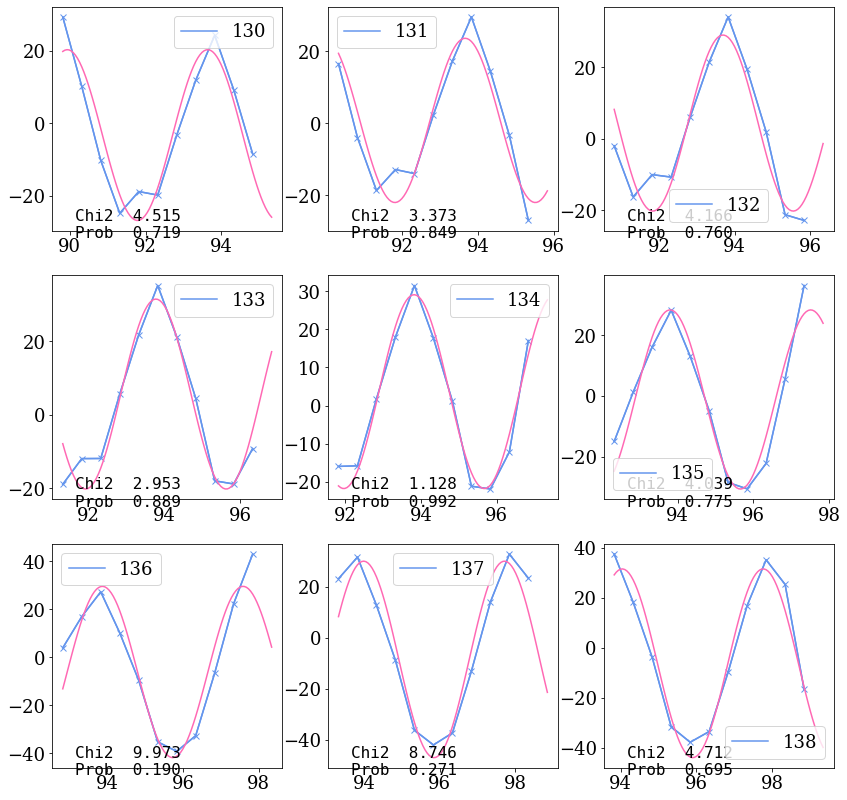

In [188]:
# Taking a closer look at some of the frames: 

i_frame = 130

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,14))

for i in range(3): 
    for j in range(3): 
        idx = i_frame + i*3 + j 
        ax[i,j].plot(t[idx:idx+datapoints], new_frames_p0[idx], color='cornflowerblue', label=f'{idx}')
        ax[i,j].plot(t[idx:idx+datapoints], new_frames_p0[idx], marker='x', color='cornflowerblue')
        
        s = {'Chi2':   Chi2_p0[idx],
             'Prob':   Pval_p0[idx]}

        text = nice_string_output(s, extra_spacing=2, decimals=3)
        add_text_to_ax(0.1, 0.1, text, ax[i,j], fontsize=16, color='black')
        ax[i,j].legend()
        taxis = np.linspace(t[idx], t[idx+datapoints], 100)
        ax[i,j].plot(taxis, fit_func(taxis, *fit_values_p0[idx][:]), color='hotpink')

In [277]:
# Getting the data from the function: 

offsets_p0 = [fit_values_p0[i][0] for i in range(len(fit_values_p0))]
amplitudes_p0 = [fit_values_p0[i][1] for i in range(len(fit_values_p0))] 
frequencies_p0 = [fit_values_p0[i][2] for i in range(len(fit_values_p0))]
phases_p0 = [fit_values_p0[i][3] for i in range(len(fit_values_p0))]

offsets_err_p0 = [fit_errors_p0[i][0] for i in range(len(fit_errors_p0))]
amplitudes_err_p0 = [fit_errors_p0[i][1] for i in range(len(fit_errors_p0))] 
frequencies_err_p0 = [fit_errors_p0[i][2] for i in range(len(fit_errors_p0))]
phases_err_p0 = [fit_errors_p0[i][3] for i in range(len(fit_errors_p0))]

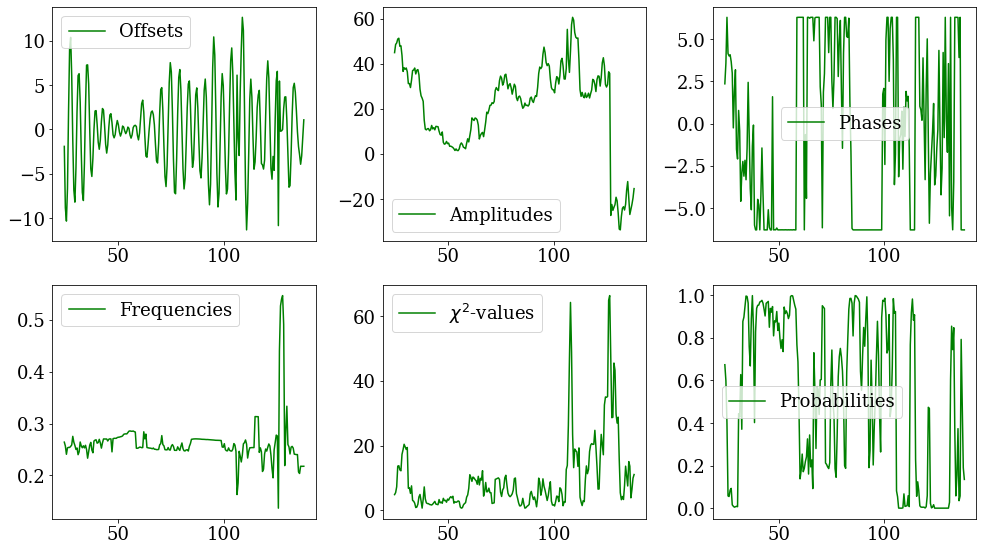

In [278]:
# Plotting the fit values: 

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,8))

ax[0,0].plot(t[:-datapoints], offsets_p0, color='green', label='Offsets')
ax[0,1].plot(t[:-datapoints], amplitudes_p0, color='green', label='Amplitudes')
ax[0,2].plot(t[:-datapoints], phases_p0, color='green', label='Phases')

ax[1,0].plot(t[:-datapoints], frequencies_p0, color='green', label='Frequencies')
ax[1,1].plot(t[:-datapoints], Chi2_p0, color='green', label=r'$\chi^2$-values')
ax[1,2].plot(t[:-datapoints], Pval_p0, color='green', label='Probabilities')

for i in range(2): 
    for j in range(3): 
        ax[i, j].legend()

fig.tight_layout()

if save_plots: 
    fig.savefig(r'Graphs/FitParamsP0.png')

In [192]:
# Doing the same thing for mdm2 cell trace 0:

offset_m0, amp_m0, freq_m0, phase_m0 = 0, 30, 0.2, np.pi
initial_m0 = [offset_m0, amp_m0, freq_m0, phase_m0]


fig, ax = plt.subplots(figsize=(14,7))
fit_values_m0, fit_errors_m0, Chi2_m0, Pval_m0, new_frames_m0 = fit_by_frame(t, roll_resi_m[0], datapoints, 
                                                              tend_line, fit_func, avefluct_m, initial_m0, ax=None);

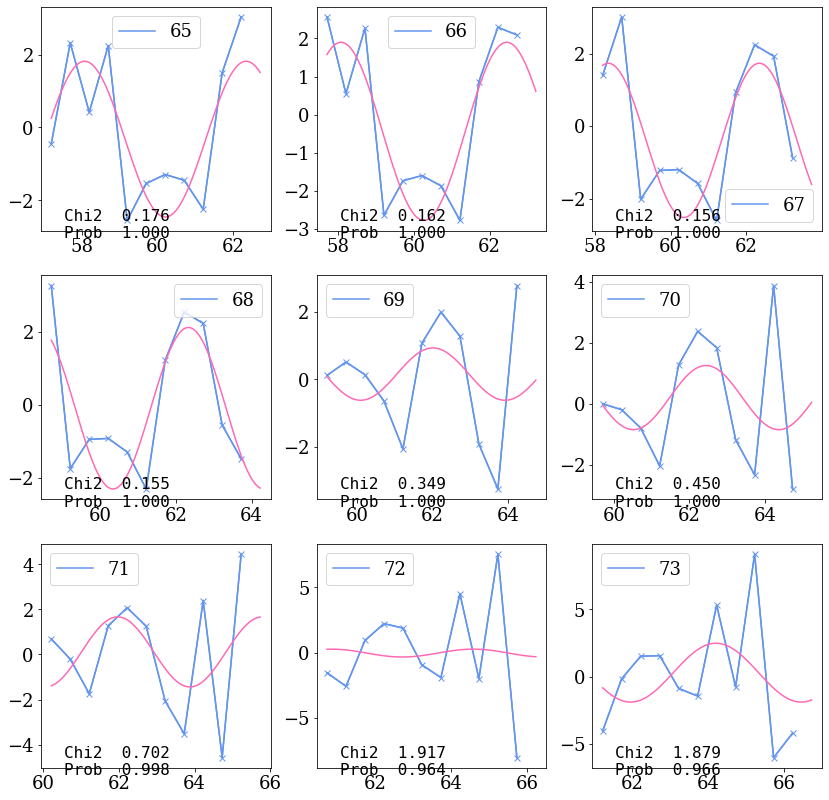

In [193]:
i_frame = 65

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,14))

for i in range(3): 
    for j in range(3): 
        idx = i_frame + i*3 + j 
        ax[i,j].plot(t[idx:idx+datapoints], new_frames_m0[idx], color='cornflowerblue', label=f'{idx}')
        ax[i,j].plot(t[idx:idx+datapoints], new_frames_m0[idx], marker='x', color='cornflowerblue')
        
        s = {'Chi2':   Chi2_m0[idx],
             'Prob':   Pval_m0[idx]}

        text = nice_string_output(s, extra_spacing=2, decimals=3)
        add_text_to_ax(0.1, 0.1, text, ax[i,j], fontsize=16, color='black')
        ax[i,j].legend()
        taxis = np.linspace(t[idx], t[idx+datapoints], 100)
        ax[i,j].plot(taxis, fit_func(taxis, *fit_values_m0[idx][:]), color='hotpink')

In [279]:
# Getting the data from the function: 

offsets_m0 = [fit_values_m0[i][0] for i in range(len(fit_values_m0))]
amplitudes_m0 = [fit_values_m0[i][1] for i in range(len(fit_values_m0))] 
frequencies_m0 = [fit_values_m0[i][2] for i in range(len(fit_values_m0))]
phases_m0 = [fit_values_m0[i][3] for i in range(len(fit_values_m0))]


offsets_err_m0 = [fit_errors_m0[i][0] for i in range(len(fit_errors_m0))]
amplitudes_err_m0 = [fit_errors_m0[i][1] for i in range(len(fit_errors_m0))] 
frequencies_err_m0 = [fit_errors_m0[i][2] for i in range(len(fit_errors_m0))]
phases_err_m0 = [fit_errors_m0[i][3] for i in range(len(fit_errors_m0))]

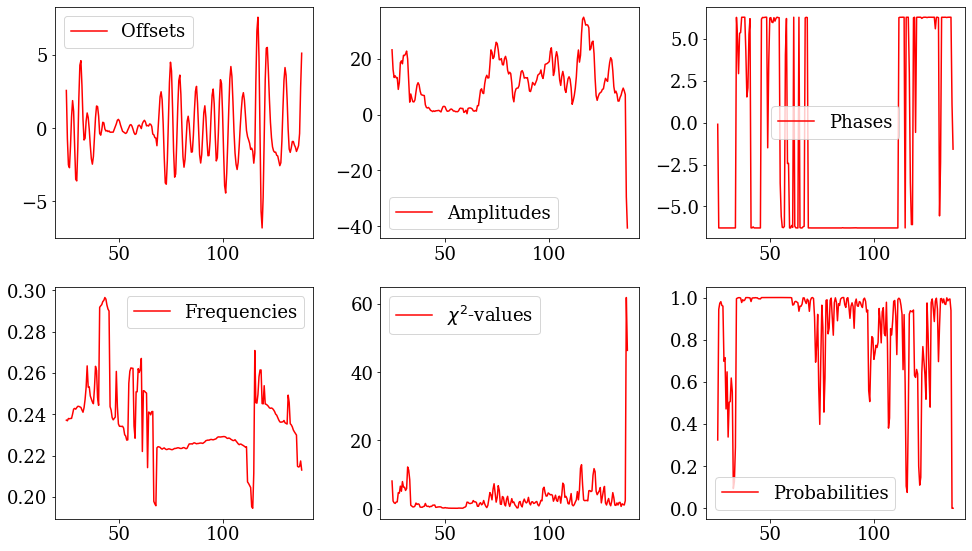

In [280]:
# Plotting the fit values: 

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,8))

ax[0,0].plot(t[:-datapoints], offsets_m0, color='red', label='Offsets')
ax[0,1].plot(t[:-datapoints], amplitudes_m0, color='red', label='Amplitudes')
ax[0,2].plot(t[:-datapoints], phases_m0, color='red', label='Phases')

ax[1,0].plot(t[:-datapoints], frequencies_m0, color='red', label='Frequencies')
ax[1,1].plot(t[:-datapoints], Chi2_m0, color='red', label=r'$\chi^2$-values')
ax[1,2].plot(t[:-datapoints], Pval_m0, color='red', label='Probabilities')

for i in range(2): 
    for j in range(3): 
        ax[i, j].legend()

fig.tight_layout()

if save_plots: 
    fig.savefig(r'Graphs/FitParamsM0.png')

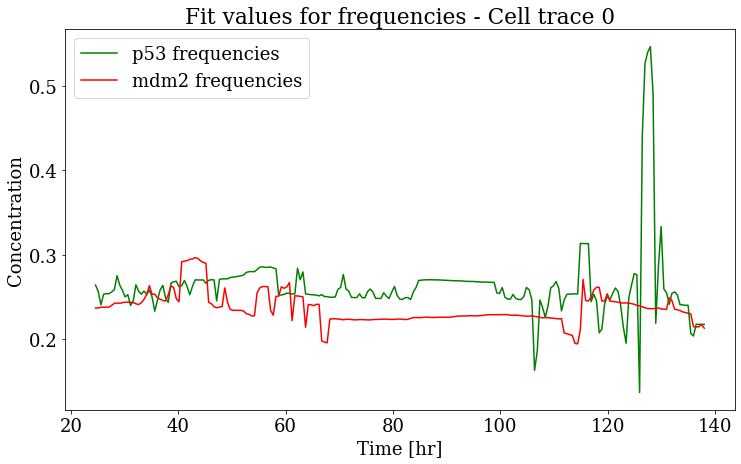

In [229]:
# Fit frequencies as a function of time for first cell trace: 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,7))

ax.plot(t[:-datapoints], frequencies_p0, color='green', label='p53 frequencies')
ax.plot(t[:-datapoints], frequencies_m0, color='red', label='mdm2 frequencies')

ax.set(xlabel='Time [hr]', 
       ylabel='Concentration', 
       title='Fit values for frequencies - Cell trace 0')

ax.legend()

if save_plots: 
    fig.savefig(r'Graphs/FitFreqsBoth.png')

In [249]:
# Finding the probability of fitting a flat line: 

run_straight_fit = False 

if run_straight_fit: 
    Chi2_straight_p = []
    Pval_straight_p = []

    Chi2_straight_m = []
    Pval_straight_m = []

    for i in range(len(resi_p)): 
        Chi2_straight_p.append(is_straight_better(t, resi_p[i], datapoints, poly0, avefluct_m)[0])
        Pval_straight_p.append(is_straight_better(t, resi_p[i], datapoints, poly0, avefluct_m)[1])

        Chi2_straight_m.append(is_straight_better(t, roll_resi_m[i], datapoints, poly0, avefluct_m)[0])
        Pval_straight_m.append(is_straight_better(t, roll_resi_m[i], datapoints, poly0, avefluct_m)[1])
        
    np.savetxt(r'Data/Straight_Chi2_p.csv', Chi2_straight_p, delimiter=',')
    np.savetxt(r'Data/Straight_Pval_p.csv', Pval_straight_p, delimiter=',')

    np.savetxt(r'Data/Straight_Chi2_m.csv', Chi2_straight_m, delimiter=',')
    np.savetxt(r'Data/Straight_Pval_m.csv', Pval_straight_m, delimiter=',')

In [250]:
Chi2_straight_p = pd.read_csv(r'Data/Straight_Chi2_m.csv', header=None, index_col=None).to_numpy()
Pval_straight_p = pd.read_csv(r'Data/Straight_Pval_m.csv', header=None, index_col=None).to_numpy()

Chi2_straight_m = pd.read_csv(r'Data/Straight_Chi2_m.csv', header=None, index_col=None).to_numpy()
Pval_straight_m = pd.read_csv(r'Data/Straight_Pval_m.csv', header=None, index_col=None).to_numpy()

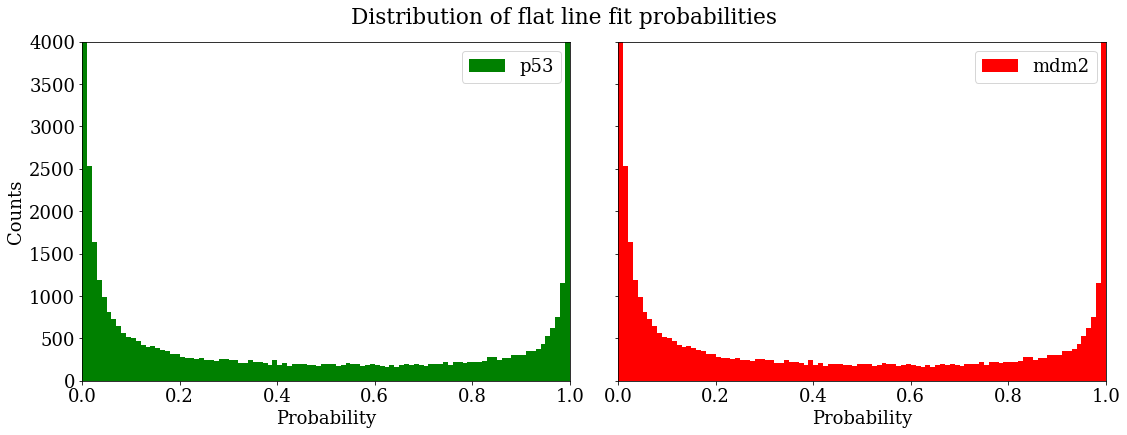

In [254]:
# Making histograms of flat line fit probabilities:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharey=True)
suptitle = fig.suptitle('Distribution of flat line fit probabilities', y=1.02)

ax[0].hist(Pval_straight_p.flatten(), bins=100, range=(0, 1), color='green', label='p53')
ax[1].hist(Pval_straight_m.flatten(), bins=100, range=(0, 1), color='red', label='mdm2')

ax[0].set(xlabel='Probability', 
          ylabel='Counts',
          xlim=(0, 1),
          ylim=(0, 4000))

ax[1].set(xlabel='Probability', 
          xlim=(0, 1), 
          ylim=(0, 4000))

ax[0].legend()
ax[1].legend()

fig.tight_layout()

if save_plots: 
    plt.savefig(r'Graphs/DistProbFlatFit.png', bbox_inches='tight', bbox_extra_artists=[suptitle]);

When the difference is around 0: equal probability of oscillations as flat line
When the difference is positive: greater probability of oscillations
When the difference is negative: greater probability of flat line


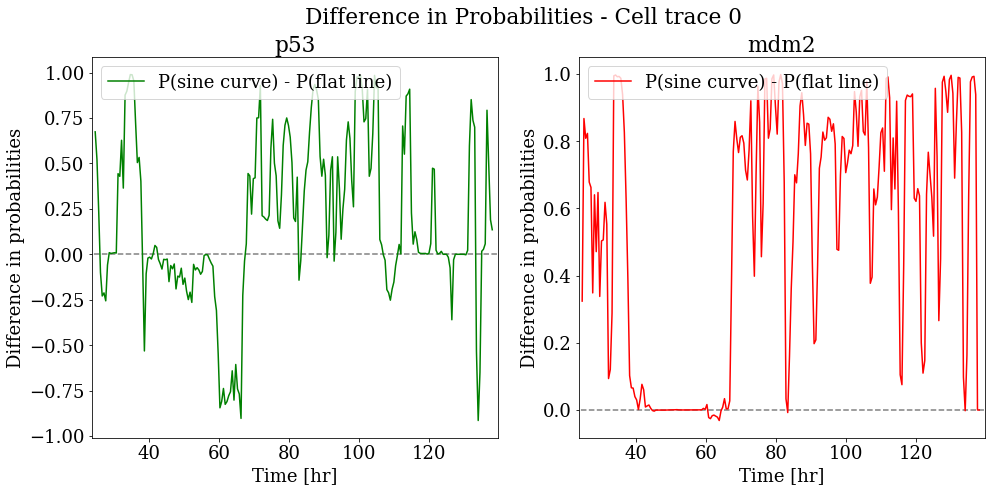

In [323]:
# Plotting difference in probability of oscillations and flat line: 

P_diff_p0 = [Pval_p0[i] - Pval_straight_p[0][i] for i in range(len(Pval_p0))]
P_diff_m0 = [Pval_m0[i] - Pval_straight_m[0][i] for i in range(len(Pval_m0))]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,7))
suptitle = fig.suptitle('Difference in Probabilities - Cell trace 0')

ax1.plot(t[:-datapoints], P_diff_p0, 
         color='green', label='P(sine curve) - P(flat line)')
ax2.plot(t[:-datapoints], P_diff_m0,
         color='red', label='P(sine curve) - P(flat line)')

ax1.set(xlabel='Time [hr]', 
        ylabel='Difference in probabilities', 
        title='p53', 
        xlim=(t[0]-1, t[-datapoints]+1))

ax2.set(xlabel='Time [hr]', 
        ylabel='Difference in probabilities', 
        title='mdm2', 
        xlim=(t[0]-1, t[-datapoints]+1))

ax1.hlines(0, t[0]-5, t[-datapoints]+5, linestyle='dashed', color='grey')
ax2.hlines(0, t[0]-5, t[-datapoints]+5, linestyle='dashed', color='grey')

ax1.legend(loc='upper left')
ax2.legend(loc='upper left');

print('When the difference is around 0: equal probability of oscillations as flat line')
print('When the difference is positive: greater probability of oscillations')
print('When the difference is negative: greater probability of flat line')

if save_plots: 
    plt.savefig(r'Graphs/DiffInP.png', bbox_inches='tight', bbox_extra_artists=[suptitle]);

In [282]:
# Getting the significance of the peaks: 

significance_p0 = np.zeros_like(amplitudes_p0)

for i in range(len(amplitudes_p0)): 
    if amplitudes_err_p0[i] == 0:    # If the fit didn't converge use 20 as the fit error: 
        significance_p0[i] = abs(amplitudes_p0[i])/20
    else: 
        significance_p0[i] = abs(amplitudes_p0[i])/amplitudes_err_p0[i]


# Finding the peaks with low significance: 
low_signi_p0 = significance_p0[significance_p0 < 3]   
low_signi_idx_p0 = np.array([np.where(significance_p0 < 3)])


# Doing the same for the mdm2 trace: 
significance_m0 = np.zeros_like(amplitudes_m0)


for i in range(len(amplitudes_m0)): 
    if amplitudes_err_m0[i] == 0: 
        significance_m0[i] = abs(amplitudes_m0[i])/20
    else: 
        significance_m0[i] = abs(amplitudes_m0[i])/amplitudes_err_m0[i]


low_signi_m0 = significance_m0[significance_m0 < 3]
low_signi_idx_m0 = np.array([np.where(significance_m0 < 3)])

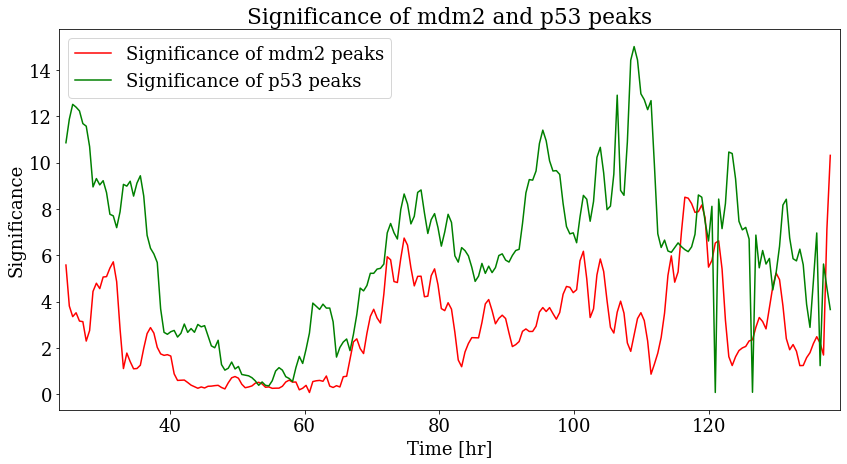

In [283]:
# Plotting the significance of the peak along with the difference in probability for oscillations vs flat line: 

fig, ax = plt.subplots(figsize=(14,7))

ax.plot(t[:-datapoints], significance_m0, color='red', label='Significance of mdm2 peaks')
ax.plot(t[:-datapoints], significance_p0, color='green', label='Significance of p53 peaks')

ax.set(xlim=(t[0]-1, t[-datapoints]+1), 
       xlabel='Time [hr]', 
       ylabel='Significance', 
       title='Significance of mdm2 and p53 peaks' )

#ax2 = ax.twinx()
#ax2.plot(t[:-datapoints], [Pval_m0[i] - Pval_straight_m0[i] for i in range(len(Pval_m0))],
         #color='red', label=r'$P_m$(sine curve) - $P_m$(flat line)')

#ax2.set(ylabel='Difference in probability')

ax.legend()
#ax2.legend()

#ax2.hlines(0, t[0]-1, t[-datapoints]+1, linestyle='dashed', color='grey')

if save_plots: 
    plt.savefig(r'Graphs/SigniVsProb.png')

In [162]:
run_fitting = False 

if run_fitting: 

    fit_values_p = [] 
    fit_errors_p = [] 
    Chi2_p = [] 
    Pval_p = [] 
    new_frames_p = []

    fit_values_m = [] 
    fit_errors_m = [] 
    Chi2_m = [] 
    Pval_m = [] 
    new_frames_m = []
    

    for i in range(len(resi_p)): 
        print(i)
        vals_p, errs_p, chi2s_p, Pvals_p, frames_p = fit_by_frame(t, resi_p[i], datapoints, 
                                                tend_line, fit_func, avefluct_m, initial_p0, ax=None);

        vals_m, errs_m, chi2s_m, Pvals_m, frames_m = fit_by_frame(t, roll_resi_m[i], datapoints, 
                                                tend_line, fit_func, avefluct_m, initial_m0, ax=None);


        fit_values_p.append(vals_p)
        fit_errors_p.append(errs_p)
        Chi2_p.append(chi2s_p)
        Pval_p.append(Pvals_p)
        new_frames_p.append(frames_p)

        fit_values_m.append(vals_m)
        fit_errors_m.append(errs_m)
        Chi2_m.append(chi2s_m)
        Pval_m.append(Pvals_m)
        new_frames_m.append(frames_m)
        

    # Getting the results from fitting_by_frame into format, that can be saved as csv-files: 

    extended_fit_values_p = [fit_values for residuals_p in fit_values_p for fit_values in residuals_p]
    extended_fit_errors_p = [fit_errors for residuals_p in fit_errors_p for fit_errors in residuals_p] 
    extended_Chi2_p = [chi2s for residuals_p in Chi2_p for chi2s in residuals_p]  
    extended_Pval_p = [pvals for residuals_p in Pval_p for pvals in residuals_p]  
    extended_new_frames_p = [frames for residuals_p in new_frames_p for frames in residuals_p] 

    extended_fit_values_m = [fit_values for residuals_m in fit_values_m for fit_values in residuals_m] 
    extended_fit_errors_m = [fit_errors for residuals_m in fit_errors_m for fit_errors in residuals_m] 
    extended_Chi2_m = [chi2s for residuals_m in Chi2_m for chi2s in residuals_m]  
    extended_Pval_m = [pvals for residuals_m in Pval_m for pvals in residuals_m] 
    extended_new_frames_m = [frames for residuals_m in new_frames_m for frames in residuals_m] 

In [158]:
# If we want to save as csv-files: 
save_fits = False

if save_fits:
    np.savetxt(r'Data/fitvalues_p.csv', extended_fit_values_p, delimiter=',')
    np.savetxt(r'Data/fiterrors_p.csv', extended_fit_errors_p, delimiter=',')
    np.savetxt(r'Data/Chi2_p.csv', extended_Chi2_p, delimiter=',')
    np.savetxt(r'Data/Pvals_p.csv', extended_Pval_p, delimiter=',')
    np.savetxt(r'Data/newframes_p.csv', extended_new_frames_p, delimiter=',')
    
    np.savetxt(r'Data/fitvalues_m.csv', extended_fit_values_m, delimiter=',')
    np.savetxt(r'Data/fiterrors_m.csv', extended_fit_errors_m, delimiter=',')
    np.savetxt(r'Data/Chi2_m.csv', extended_Chi2_m, delimiter=',')
    np.savetxt(r'Data/Pvals_m.csv', extended_Pval_m, delimiter=',')
    np.savetxt(r'Data/newframes_m.csv', extended_new_frames_m, delimiter=',')

In [ ]:
extended_fit_values_p = pd.read_csv(r'Data/fitvalues_p.csv', header=None, index_col=None).to_numpy()
extended_fit_errors_p = pd.read_csv(r'Data/fiterrors_p.csv', header=None, index_col=None).to_numpy()
extended_Chi2_p = pd.read_csv(r'Data/Chi2_p.csv', header=None, index_col=None).to_numpy()
extended_Pval_p = pd.read_csv(r'Data/Pvals_p.csv', header=None, index_col=None).to_numpy()
extended_new_frames_p = pd.read_csv(r'Data/newframes_p.csv', header=None, index_col=None).to_numpy()

extended_fit_values_m = pd.read_csv(r'Data/fitvalues_m.csv', header=None, index_col=None).to_numpy()
extended_fit_errors_m = pd.read_csv(r'Data/fiterrors_m.csv', header=None, index_col=None).to_numpy()
extended_Chi2_m = pd.read_csv(r'Data/Chi2_m.csv', header=None, index_col=None).to_numpy()
extended_Pval_m = pd.read_csv(r'Data/Pvals_m.csv', header=None, index_col=None).to_numpy()
extended_new_frames_m = pd.read_csv(r'Data/newframes_m.csv', header=None, index_col=None).to_numpy()

In [729]:
fit_amps_p = np.array(extended_fit_values_p)[:,0]
fit_amps_err_p = abs(np.array(extended_fit_errors_p)[:,0])

fit_freqs_p = np.array(extended_fit_values_p)[:,2]

fit_amps_m = np.array(extended_fit_values_m)[:,0]
fit_amps_err_m = np.array(extended_fit_errors_m)[:,0]

fit_freqs_m = np.array(extended_fit_values_m)[:,2]

In [730]:
freqs_p_trace = [fit_freqs_p[i*227:227*(i+1)] for i in range(402)]
amps_p_trace = [fit_amps_p[i*227:227*(i+1)] for i in range(402)]
freqs_p_trace_mean = np.mean(freqs_p_trace, axis=0)
amps_p_trace_mean = np.mean(amps_p_trace, axis=0)

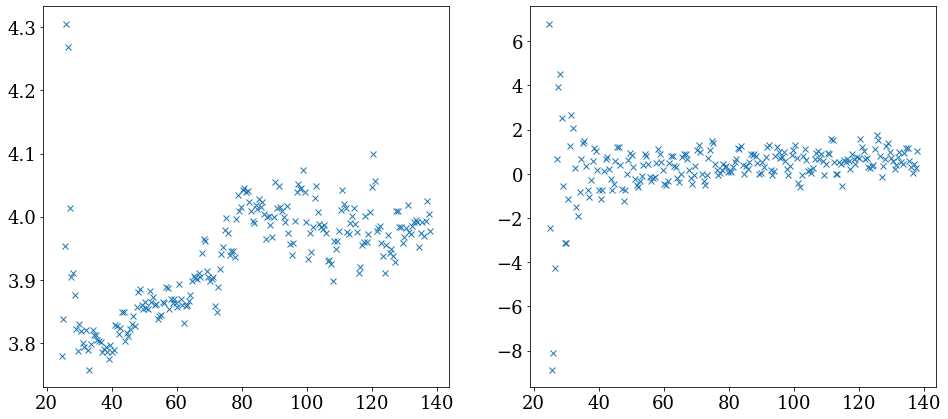

In [745]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

ax[0].plot(t[:-datapoints], 1/(freqs_p_trace_mean), 'x')

ax[1].plot(t[:-datapoints], amps_p_trace_mean, 'x')


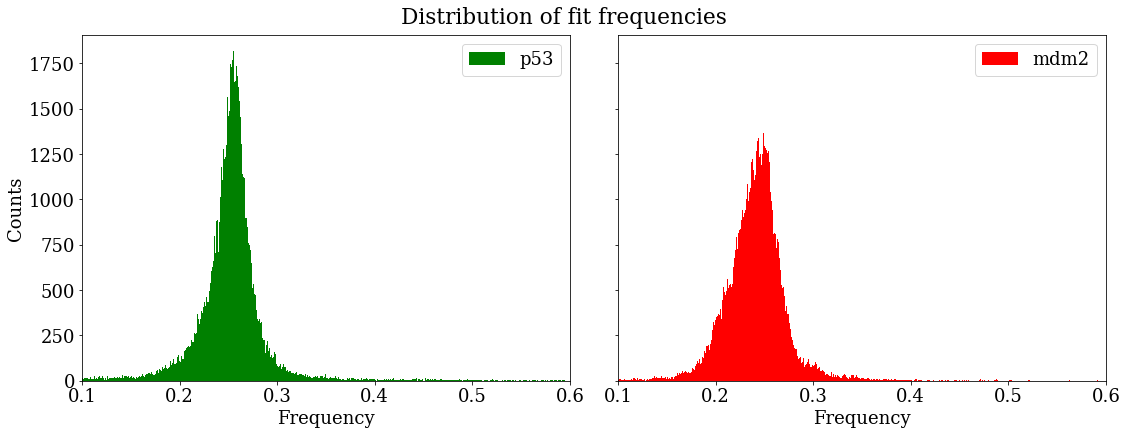

In [219]:
# Making histograms of fit frequencies:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharey=True)
suptitle = fig.suptitle('Distribution of fit frequencies', y=1.02)

ax[0].hist(fit_freqs_p, bins=1000, range=(0, 0.8), color='green', label='p53')
ax[1].hist(fit_freqs_m, bins=1000, range=(0, 0.8), color='red', label='mdm2')

ax[0].set(xlabel='Frequency', 
          ylabel='Counts',
          xlim=(0.1, 0.6))

ax[1].set(xlabel='Frequency', 
          xlim=(0.1, 0.6))

ax[0].legend()
ax[1].legend()

fig.tight_layout()

if save_plots: 
    plt.savefig(r'Graphs/DistFreqsFit.png', bbox_inches='tight', bbox_extra_artists=[suptitle]);

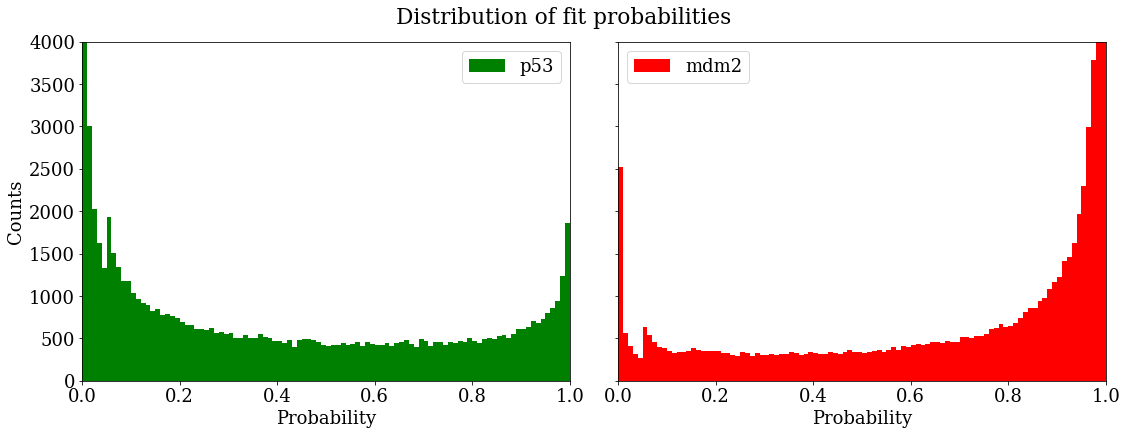

In [255]:
# Making histograms of fit probabilities:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharey=True)
suptitle = fig.suptitle('Distribution of fit probabilities', y=1.02)

ax[0].hist(extended_Pval_p, bins=100, range=(0, 1), color='green', label='p53')
ax[1].hist(extended_Pval_m, bins=100, range=(0, 1), color='red', label='mdm2')

ax[0].set(xlabel='Probability', 
          ylabel='Counts',
          xlim=(0, 1),
          ylim=(0, 4000))

ax[1].set(xlabel='Probability', 
          xlim=(0, 1), 
          ylim=(0, 4000))

ax[0].legend()
ax[1].legend()

fig.tight_layout()

if save_plots: 
    plt.savefig(r'Graphs/DistProbOsciFit.png', bbox_inches='tight', bbox_extra_artists=[suptitle]);

In [316]:
# Getting the significance of the peaks: 

significance_p = np.zeros_like(fit_amps_p)
significance_m = np.zeros_like(fit_amps_m)

for i in range(len(fit_amps_p)): 
    if fit_amps_err_p[i] == 0:    # If the fit didn't converge use 20 as the fit error: 
        significance_p[i] = abs(fit_amps_p[i])/20
    else: 
        significance_p[i] = abs(fit_amps_p[i])/fit_amps_err_p[i]
        
    if fit_amps_err_m[i] == 0:   
        significance_m[i] = abs(fit_amps_m[i])/20
    else: 
        significance_m[i] = abs(fit_amps_m[i])/fit_amps_err_m[i]


# Finding the peaks with low significance: 
low_signi_p = significance_p[significance_p < 3]   
low_signi_idx_p = np.array([np.where(significance_p < 3)])


low_signi_m = significance_m[significance_m < 3]
low_signi_idx_m = np.array([np.where(significance_m < 3)])

In [461]:
# Finding the difference in normalized significance for each trace:

diff_signi_norm = []
diff_signi = [] 
fitTrace = len(t) - datapoints

for i in range(len(resi_p)): 
    signi_p = significance_p[fitTrace*i:fitTrace*(i+1)]
    signi_m = significance_m[fitTrace*i:fitTrace*(i+1)]
    
    diff_signi_norm.append(signi_p/max(signi_p) - signi_m/max(signi_m))
    diff_signi.extend(signi_p - signi_m)

In [610]:
# Finding indices, where there is a big difference in the significance of p53 and mdm2 peaks: 

mean_diff_norm = np.mean(diff_signi_norm, axis=1)
sigma_diff_norm = np.std(diff_signi_norm, axis=1, ddof=1) #/ np.sqrt(len(diff_signi_norm[0]))


big_diff = mean_diff_norm + sigma_diff_norm
print(f'The mean difference cut is: {np.mean(big_diff):0.2f}')

idx_big_signi_diff = []

for i in range(len(diff_signi_norm)): 
    
    idx_signi = []
    
    for j in range(len(diff_signi_norm[i])): 
         
        if diff_signi_norm[i][j] >= big_diff[i]: 
            idx_signi.append(j)
            
    idx_big_signi_diff.append(idx_signi)   

The mean difference cut is: 0.27


In [463]:
# Getting the gradient in the areas of big significance difference: 

gradients = np.gradient(roll_resi_m, axis=1)

gradients_bigdiff = []
gradients_bigdiff_idx = []

for i in range(len(idx_big_signi_diff)): 
    
    grad_bd = []
    grad_bd_idx = []
    
    for j in idx_big_signi_diff[i]: 
        if j > 222: 
            grad_bd.append(gradients[i][j-5:])
            grad_bd_idx.append(np.arange(j-5, 228, 1))
        elif j < 5: 
            grad_bd.append(gradients[i][:j+5])
            grad_bd_idx.append(np.arange(0, j+5, 1))
        else: 
            grad_bd.append(gradients[i][j-5:j+5])
            grad_bd_idx.append(np.arange(j-5, j+5, 1))
        
    gradients_bigdiff.append(grad_bd)
    gradients_bigdiff_idx.append(grad_bd_idx) 

In [505]:
# Checking the gradients: 

max_grad_neg = []
max_grad_neg_idx = [] 
max_grad_not_None = [] 

for i in range(len(gradients_bigdiff)): 
    
    grad_neg = []
    grad_neg_idx = []
    
    for j in range(len(gradients_bigdiff[i])): 
        if np.max(gradients_bigdiff[i][j]) <= 0: 
            grad_neg.append(gradients_bigdiff[i][j])
            grad_neg_idx.append(gradients_bigdiff_idx[i][j])
    
    if len(grad_neg) == 0: 
        max_grad_neg.append(None)
        max_grad_neg_idx.append(None)
    else: 
        max_grad_neg.append(grad_neg)
        max_grad_neg_idx.append(grad_neg_idx)
        max_grad_not_None.append(i)

# Counting the areas with only negative or zero gradient: 
max_grad_neg_count = 0 

for i in max_grad_neg: 
    if not i == None: 
        max_grad_neg_count += 1
        
print(f'Number of areas with big difference in significance and negative/zero-gradient: {max_grad_neg_count}')

Number of areas with big difference in significance and negative/zero-gradient: 117


In [612]:
# Using own peak finding function to get minima as well: 

all_peaks_p = [] 
all_peaks_m = [] 

all_local_min_p = []
all_local_min_m = []

for i in range(len(resi_p)): 
    
    peaks_p, min_p = peak_finder(resi_p[i], N_peaks='high', threshold=avefluct_m)
    peaks_m, min_m = peak_finder(roll_resi_m[i], N_peaks='low', threshold=avefluct_m)
    
    all_peaks_p.append(peaks_p)
    all_peaks_m.append(peaks_m)
    
    all_local_min_p.append(get_min_idx(resi_p[i], min_p))
    all_local_min_m.append(get_min_idx(roll_resi_m[i], min_m))

In [689]:
# Getting the peaks in areas of big significance difference: 

p53_peaks_bigdiff = [] 
p53_peaks_bigdiff_idx = [] 
peaks_indices = []

for i in range(len(idx_big_signi_diff)):  # Looping through all traces 
    
    peaks_bd = []
    peaks_bd_idx = []
    peaks_idx = []
    
    for j in idx_big_signi_diff[i]:   # Looping through the indices of big difference 
        
        if j < 4: 
            peak_idx = np.where(np.isclose(resi_p[i], np.max(resi_p[i][:j+4])))[0][0]
            peaks_idx.append(peak_idx)
            
            if np.searchsorted(all_local_min_p[i], peak_idx) == 0: 
                min_idx = all_local_min_p[i][np.searchsorted(all_local_min_p[i], peak_idx)]
                peaks_bd.append(resi_p[i][:min_idx + 1])
                peaks_bd_idx.append(np.arange(0, min_idx + 1, 1))
                
            else: 
                min_start_idx = all_local_min_p[i][np.searchsorted(all_local_min_p[i], peak_idx) - 1]
                min_end_idx = all_local_min_p[i][np.searchsorted(all_local_min_p[i], peak_idx)]
                peaks_bd.append(resi_p[i][min_start_idx:min_end_idx + 1])
                peaks_bd_idx.append(np.arange(min_start_idx, min_end_idx + 1, 1))
        
        
        elif j > 223: 
            peak_idx = np.where(np.isclose(resi_p[i], np.max(resi_p[i][j-4:])))[0][0]
            peaks_idx.append(peak_idx)
            
            if np.searchsorted(all_local_min_p[i], peak_idx) >= len(all_local_min_p[i]) - 1:
                min_idx = all_local_min_p[i][-1]
                peaks_bd.append(resi_p[i][min_idx:])
                peaks_bd_idx.append(np.arange(min_idx, len(t)+1, 1))
            
            else:
                min_start_idx = all_local_min_p[i][np.searchsorted(all_local_min_p[i], peak_idx)]
                min_end_idx = all_local_min_p[i][np.searchsorted(all_local_min_p[i], peak_idx)+1]
                peaks_bd.append(resi_p[i][min_start_idx:min_end_idx + 1])
                peaks_bd_idx.append(np.arange(min_start_idx, min_end_idx + 1, 1))

            
        else: 
            peak_idx = np.where(np.isclose(resi_p[i], np.max(resi_p[i][j-4:j+4])))[0][0]
            peaks_idx.append(peak_idx)
            
            if np.searchsorted(all_local_min_p[i], peak_idx) >= len(all_local_min_p[i])-1: 
                min_idx = all_local_min_p[i][-1]
                peaks_bd.append(resi_p[i][min_idx:])
                peaks_bd_idx.append(np.arange(min_idx, len(t) + 1, 1))
            
            elif np.searchsorted(all_local_min_p[i], peak_idx) == 0: 
                min_idx = all_local_min_p[i][np.searchsorted(all_local_min_p[i], peak_idx)]
                peaks_bd.append(resi_p[i][:min_idx+1])
                peaks_bd_idx.append(np.arange(0, min_idx + 1, 1))
                
            else:
                min_start_idx = all_local_min_p[i][np.searchsorted(all_local_min_p[i], peak_idx)]
                min_end_idx = all_local_min_p[i][np.searchsorted(all_local_min_p[i], peak_idx)+1]
                peaks_bd.append(resi_p[i][min_start_idx:min_end_idx + 1])
                peaks_bd_idx.append(np.arange(min_start_idx, min_end_idx + 1, 1))


    p53_peaks_bigdiff.append(peaks_bd)
    p53_peaks_bigdiff_idx.append(peaks_bd_idx) 
    peaks_indices.append(sorted(list(set(peaks_idx))))

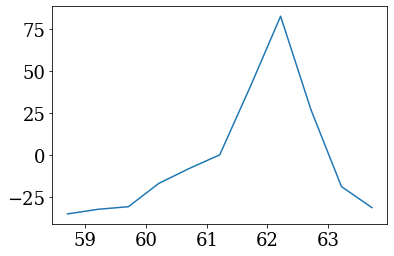

In [692]:
plt.plot(t[p53_peaks_bigdiff_idx[5][5]], p53_peaks_bigdiff[5][5])

In [694]:
# Checking the gradients in peak areas with big significance difference: 

peak_grad_neg = []
peak_grad_neg_idx = [] 
peak_grad_not_None = [] 

for i in range(len(p53_peaks_bigdiff)): 
    
    grad_neg = []
    grad_neg_idx = []
    
    for j in range(len(p53_peaks_bigdiff[i])): 
        if np.max(np.gradient(p53_peaks_bigdiff[i][j])) <= 0.3: 
            grad_neg.append(p53_peaks_bigdiff[i][j])
            grad_neg_idx.append(p53_peaks_bigdiff_idx[i][j])
    
    if len(grad_neg) == 0: 
        peak_grad_neg.append(None)
        peak_grad_neg_idx.append(None)
    else: 
        peak_grad_neg.append(grad_neg)
        peak_grad_neg_idx.append(grad_neg_idx)
        peak_grad_not_None.append(i)

# Counting the areas with only negative or zero gradient: 
peak_grad_neg_count = 0 

for i in peak_grad_neg: 
    if not i == None: 
        peak_grad_neg_count += 1
        
print(f'Number of areas with big difference in significance and negative/zero-gradient: {peak_grad_neg_count}')

Number of areas with big difference in significance and negative/zero-gradient: 0


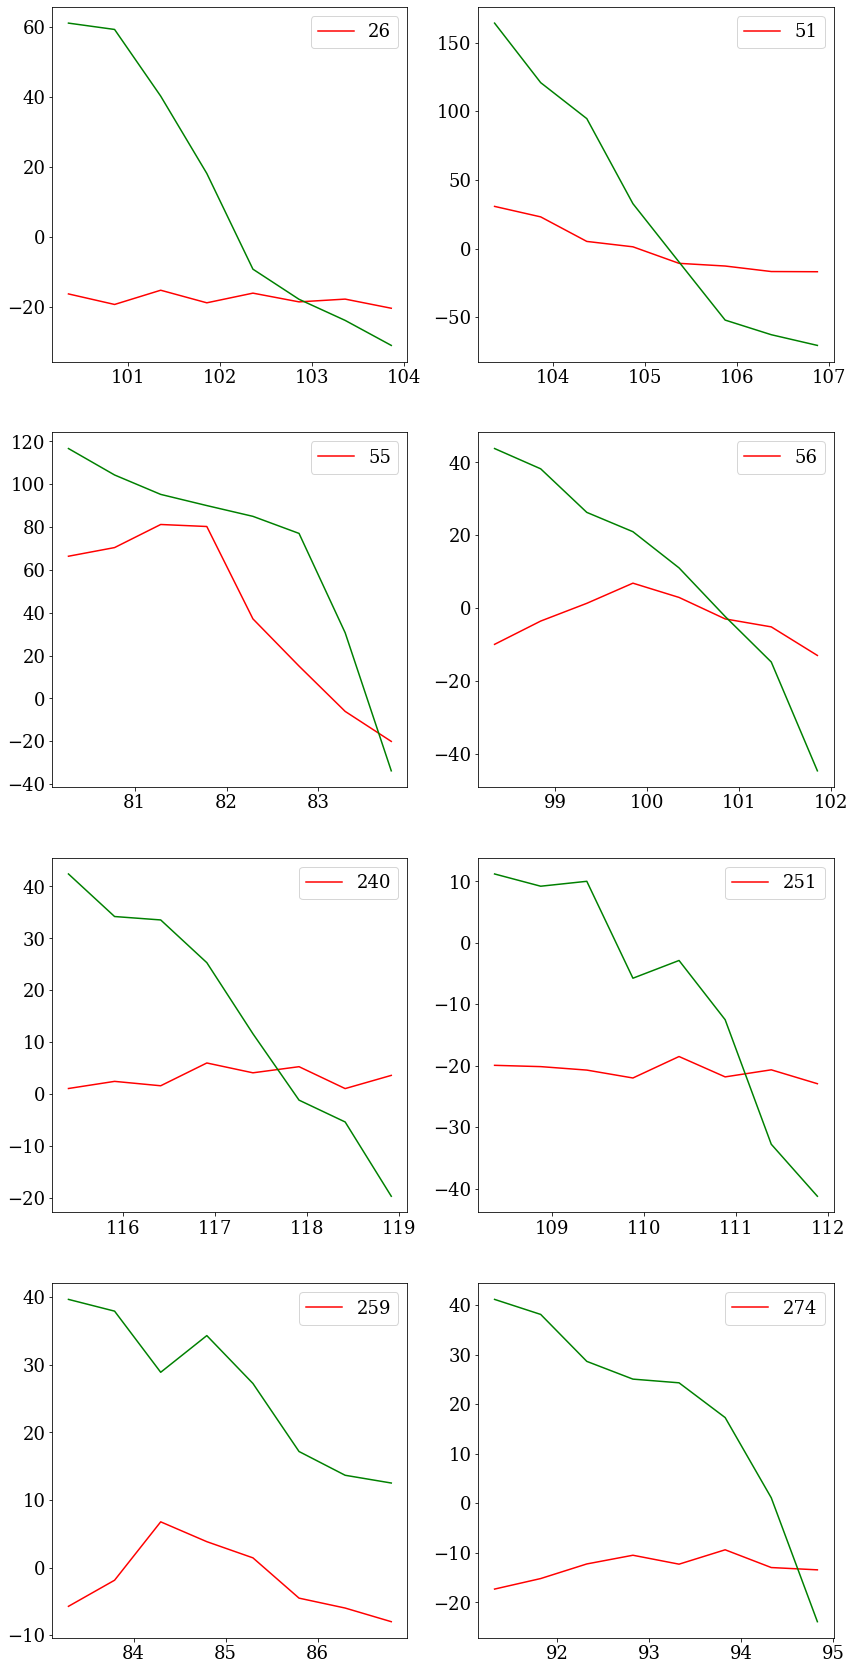

In [518]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(14, 30))

plot_frame1 = peak_grad_not_None.copy()

for i in range(4): 
    for j in range(2): 
        for k in plot_frame1:  
            ax[i, j].plot(t[peak_grad_neg_idx[k][0]], roll_resi_m[k][peak_grad_neg_idx[k][0]], color='red', label=f'{k}')
            ax[i, j].plot(t[peak_grad_neg_idx[k][0]], resi_p[k][peak_grad_neg_idx[k][0]], color='green')
            ax[i, j].legend()
            plot_frame1.remove(k)
            break

In [503]:
# Checking the gradients: 

max_grad_neg = []
max_grad_neg_idx = [] 
max_grad_not_None = [] 

for i in range(len(gradients_bigdiff)): 
    
    grad_neg = []
    grad_neg_idx = []
    
    for j in range(len(gradients_bigdiff[i])): 
        if np.max(gradients_bigdiff[i][j]) <= 0: 
            grad_neg.append(gradients_bigdiff[i][j])
            grad_neg_idx.append(gradients_bigdiff_idx[i][j])
    
    if len(grad_neg) == 0: 
        max_grad_neg.append(None)
        max_grad_neg_idx.append(None)
    else: 
        max_grad_neg.append(grad_neg)
        max_grad_neg_idx.append(grad_neg_idx)
        max_grad_not_None.append(i)

# Counting the areas with only negative or zero gradient: 
max_grad_neg_count = 0 

for i in max_grad_neg: 
    if not i == None: 
        max_grad_neg_count += 1
        
print(f'Number of areas with big difference in significance and negative/zero-gradient: {max_grad_neg_count}')

Number of areas with big difference in significance and negative/zero-gradient: 117


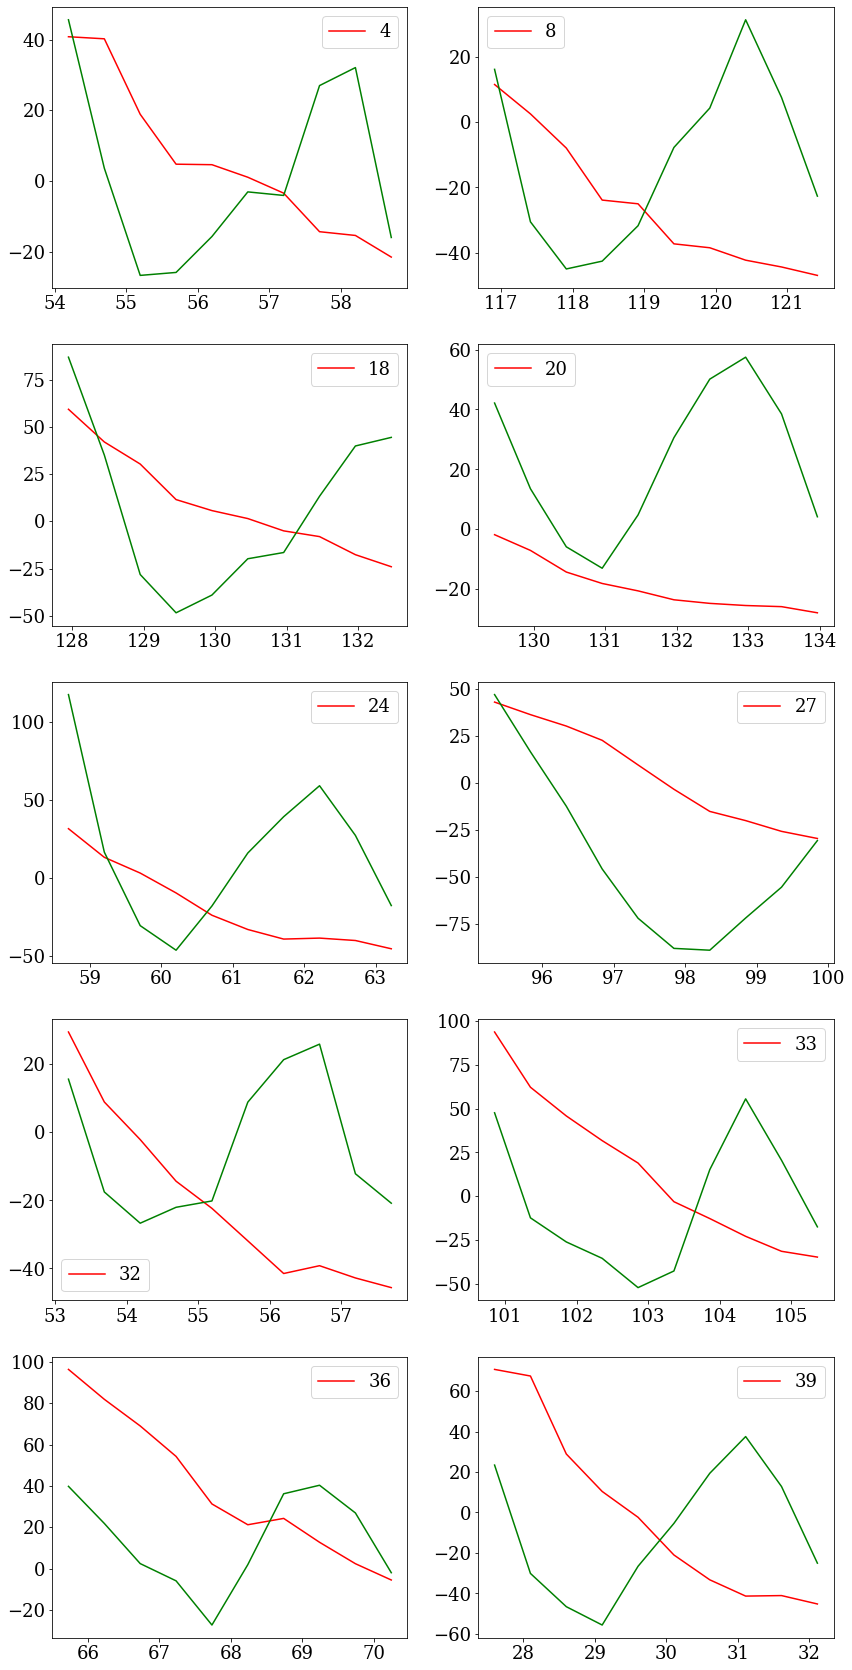

In [504]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(14, 30))

plot_frame = max_grad_not_None.copy()

for i in range(5): 
    for j in range(2): 
        for k in plot_frame:  
            ax[i, j].plot(t[max_grad_neg_idx[k][0]], roll_resi_m[k][max_grad_neg_idx[k][0]], color='red', label=f'{k}')
            ax[i, j].plot(t[max_grad_neg_idx[k][0]], resi_p[k][max_grad_neg_idx[k][0]], color='green')
            ax[i, j].legend()
            plot_frame.remove(k)
            break

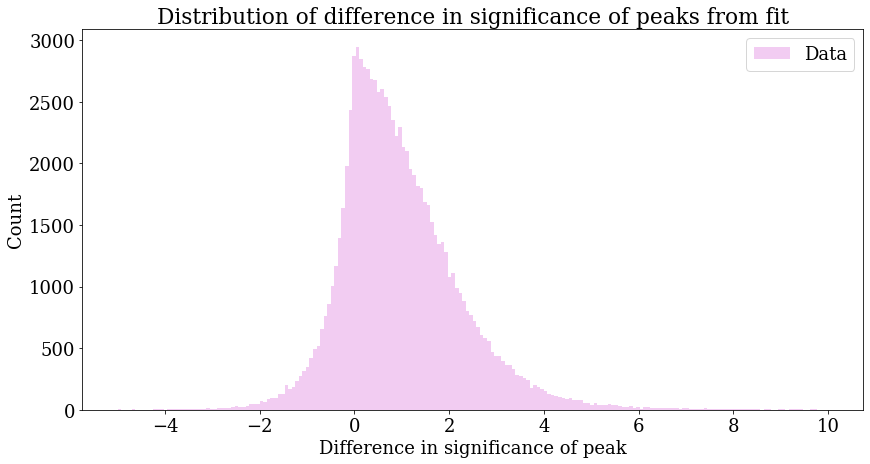

In [331]:
fig, ax = plt.subplots(figsize=(14,7))

ax.hist(diff_signi, bins=200, range=(-5, 10), color='m', alpha=0.2, label='Data')
ax.set(xlabel='Difference in significance of peak', 
       ylabel='Count',
       title='Distribution of difference in significance of peaks from fit')

ax.legend()

if save_plots: 
    plt.savefig(r'Graphs/DistDiffSigni.png', bbox_inches='tight', bbox_extra_artists=[suptitle]);

[Text(0, 0.5, 'Significance'),
 (23.585664335664337, 139.4825174825175),
 Text(0.5, 0, 'Time [hr]'),
 Text(0.5, 1.0, 'Significance of mdm2 and p53 peaks')]

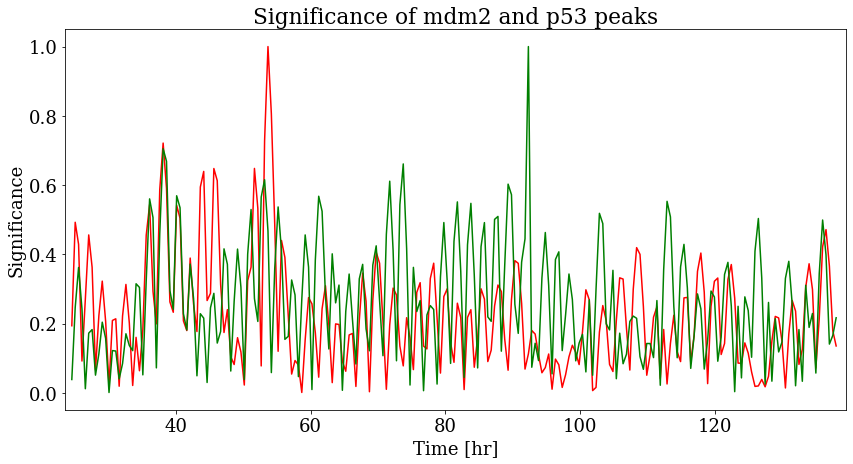

In [286]:
fig, ax = plt.subplots(figsize=(14,7))

ax.plot(t[:-datapoints], significance_m[227*3:227*4]/max(significance_m[227*3:227*4]), color='red', label='Significance of mdm2 peaks')
ax.plot(t[:-datapoints], significance_p[227*3:227*4]/max(significance_p[227*3:227*4]), color='green', label='Significance of p53 peaks')

ax.set(xlim=(t[0]-1, t[-datapoints]+1), 
       xlabel='Time [hr]', 
       ylabel='Significance', 
       title='Significance of mdm2 and p53 peaks' )